In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
import pandas as pd

In [50]:
tc_df=pd.read_csv('Telco_Customer_Churn_Data.csv')

In [51]:
tc_df['Churn'].replace({'Yes':1,'No':0},inplace=True)

In [52]:
na_df=pd.DataFrame({'columns':tc_df.columns,'null_per':tc_df.isnull().sum()/tc_df.shape[0]*100})
# no null vales

In [53]:
# non-sense columns

non_sense=[col for col in tc_df.columns if tc_df[col].nunique==1 or tc_df.nunique==tc_df.shape[0]]
non_sense   # no non-sense columns

[]

# Chi2 test

In [54]:
con_cols=[col for col in tc_df.columns if tc_df[col].dtype=='int64' or tc_df[col].dtype=='float64']

cat_cols=[col for col in tc_df.columns if tc_df[col].dtype=='object']

In [55]:
from scipy.stats import chi2_contingency

In [56]:
sig_val=0.05
chi2_corr_cols=[]
chi2_nocorr_cols=[]

for col in cat_cols:
    contingencty_table=pd.crosstab(tc_df[col],tc_df['Churn'])
    p_value=chi2_contingency(contingencty_table)[1]
    if p_value<sig_val:
        chi2_corr_cols.append(col)
    else:
        chi2_nocorr_cols.append(col)
    
print(chi2_corr_cols)
print(chi2_nocorr_cols)

['Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['customerID', 'gender', 'PhoneService', 'TotalCharges']


# Anova test

In [57]:
from scipy.stats import f_oneway

anova_corr_cols=[]
anova_non_corr_cols=[]

con_cols=[col for col in tc_df.columns if tc_df[col].dtype=='int64' or tc_df[col].dtype=='float64']

for col in con_cols:
    y_list=list(tc_df[tc_df['Churn']==1][col])
    n_list=list(tc_df[tc_df['Churn']==0][col])
    
    p_value=f_oneway(y_list,n_list)[1]
    
    if p_value<sig_val:
        anova_corr_cols.append(col)
    else:
        anova_non_corr_cols.append(col)
        

print(anova_corr_cols)
print(anova_non_corr_cols)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'Churn']
[]


# Drop columns

In [58]:
drop_columns=anova_non_corr_cols+chi2_nocorr_cols

y=tc_df['Churn']

drop_columns.append('Churn')

tc_df.drop(columns=drop_columns,inplace=True)

In [59]:
tc_df

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,Yes,Yes,24,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80
7039,0,Yes,Yes,72,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20
7040,0,Yes,Yes,11,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60
7041,1,Yes,No,4,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40


# Train-test split

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
x_train,x_test,y_train,y_test=train_test_split(tc_df,y,train_size=0.8,random_state=42)

# fill NA values

In [62]:
con_cols=[col for col in tc_df.columns if tc_df[col].dtype=='int64' or tc_df[col].dtype=='float64']
cat_cols=[col for col in tc_df.columns if tc_df[col].dtype=='object']

for col in con_cols:
    x_train[col].fillna(x_train[col].mean(),inplace=True)
    x_test[col].fillna(x_train[col].mean(),inplace=True)
    
for col in cat_cols:
    x_train[col].fillna(x_train[col].mode()[0],inplace=True)
    x_test[col].fillna(x_train[col].mode()[0],inplace=True)

# Scaling

In [63]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [64]:
std_scalar=StandardScaler()

for col in con_cols:
    x_train[col]=std_scalar.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=std_scalar.transform(np.array(x_test[col]).reshape(-1,1))

# Encoding

In [65]:
oe_train=pd.get_dummies(x_train[cat_cols])
oe_test=pd.get_dummies(x_test[cat_cols])

In [66]:
print(oe_train.shape)
print(oe_test.shape)

(5634, 37)
(1409, 37)


In [67]:
# merging both scaled and encoded columns

x_train_final=pd.concat([x_train[con_cols],oe_train],axis=1)
x_test_final=pd.concat([x_test[con_cols],oe_test],axis=1)

# Logistic regression

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
log_reg=LogisticRegression()

log_reg.fit(x_train_final,y_train)

LogisticRegression()

# LASSO and RIDGE

In [70]:
from sklearn.linear_model import SGDClassifier

lasso=SGDClassifier(penalty='l1', alpha=0.01, l1_ratio=0.15)
ridge=SGDClassifier(penalty='l2', alpha=0.01, l1_ratio=0.15)

lasso.fit(x_train_final,y_train)
ridge.fit(x_train_final,y_train)

lasso_coeffs=lasso.coef_
ridge_coeffs=ridge.coef_


len(lasso_coeffs[lasso_coeffs==0])
len(ridge_coeffs[ridge_coeffs==0])

lasso_test_pred=lasso.predict(x_test_final)
ridge_test_pred=ridge.predict(x_test_final)

from sklearn.metrics import accuracy_score

print('lasso_test_accuracy:',accuracy_score(y_test,lasso_test_pred))
print('ridge_test_accuracy:',accuracy_score(y_test,ridge_test_pred))


lasso_test_accuracy: 0.815471965933286
ridge_test_accuracy: 0.8232789212207239


In [71]:
test_pred=log_reg.predict(x_test_final)
train_pred=log_reg.predict(x_train_final)

In [72]:
probabs=log_reg.predict_proba(x_test_final)
pos_probabs=probabs[::,1]

In [73]:
# AUC-ROC curve

from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,pos_probabs)

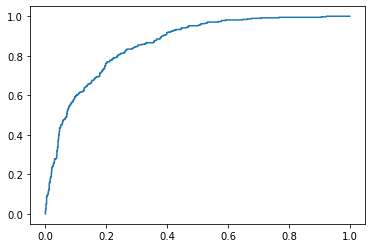

In [74]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,test_pred)

0.7444452782924633

In [76]:
# Confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,test_pred)

array([[937,  99],
       [155, 218]], dtype=int64)

In [77]:
# recall

from sklearn.metrics import recall_score

recall_score(y_test,test_pred)

0.5844504021447721

In [78]:
# precision

from sklearn.metrics import precision_score

precision_score(y_test,test_pred)

0.6876971608832808

In [79]:
# accuracy

from sklearn.metrics import accuracy_score

print(accuracy_score(y_train,train_pred))  # train accuracy
print(accuracy_score(y_test,test_pred)) # test accuracy

0.8008519701810437
0.8197303051809794


In [80]:
# f1-score

from sklearn.metrics import f1_score

f1_score(y_test,test_pred)

0.6318840579710144

# DECISION TREE

In [81]:
from sklearn.tree import DecisionTreeClassifier

d_tree=DecisionTreeClassifier(criterion='entropy',max_depth=10)

d_tree.fit(x_train_final,y_train)

d_tree_test_pred=d_tree.predict(x_test_final)
d_tree_train_pred=d_tree.predict(x_train_final)

d_tree_probabs=d_tree.predict_proba(x_test_final)
pos_probabs=d_tree_probabs[::,1]

# auc-roc curve
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_test,pos_probabs)

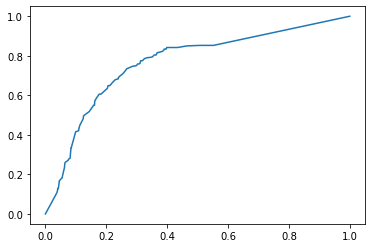

In [82]:
import matplotlib.pyplot as plt

plt.plot(fpr,tpr)

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,d_tree_test_pred)

0.6859984266150486

In [84]:
# confusion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,d_tree_test_pred)

array([[902, 134],
       [186, 187]], dtype=int64)

In [85]:
from sklearn.metrics import precision_score

precision_score(y_test,d_tree_test_pred)

0.5825545171339563

In [86]:
from sklearn.metrics import recall_score

recall_score(y_test,d_tree_test_pred)

0.5013404825737265

In [87]:
from sklearn.metrics import f1_score 

f1_score(y_test,d_tree_test_pred)

0.5389048991354468

In [88]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_train,d_tree_train_pred)) # Train accuracy
print(accuracy_score(y_test,d_tree_test_pred)) # Test accuracy

0.8565850195243166
0.772888573456352


# RANDOM FOREST MODEL

In [89]:
from sklearn.ensemble import RandomForestClassifier

rf_c=RandomForestClassifier()

rf_c.fit(x_train_final,y_train)
rf_test_pred=rf_c.predict(x_test_final)
rf_train_pred=rf_c.predict(x_train_final)

In [103]:
from sklearn.metrics import accuracy_score

print('Train Score:',accuracy_score(y_train,rf_train_pred))
print('Test Score:',accuracy_score(y_test,rf_test_pred))

Train Score: 0.997515086971956
Test Score: 0.7920511000709723


# HYPER PARAMETER TUNING

# GRID SEARCH

In [91]:
# FOR DECISION TREE MODEL

from sklearn.model_selection import GridSearchCV

dt_c=DecisionTreeClassifier()

param_grid_dict={'max_depth':[4,5,6,7,9],'min_samples_split':[4,5,6,7,8],'min_samples_leaf':[3,4,5,6,7],'max_leaf_nodes':[3,4,5,6,7]}

gcv=GridSearchCV(dt_c,param_grid=param_grid_dict,cv=5,verbose=17)

gcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 625 candidates, totalling 3125 fits
[CV 1/5; 1/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 1/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 1/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 1/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 1/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 1/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 1/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 1/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 1/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 1/625] END max_dep

[CV 2/5; 9/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 9/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 9/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 9/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 9/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 9/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 9/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 10/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 10/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 10/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=

[CV 3/5; 18/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 18/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 18/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 18/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=6
[CV 5/5; 18/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 1/5; 19/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 19/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 19/625] START max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 19/625] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 3/5; 19/625] START max_depth=4, max_leaf_nodes=3, min_sample

[CV 4/5; 26/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 26/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 26/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 27/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 27/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 27/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 27/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 27/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 27/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 27/625] START max_depth=4, max_leaf_nodes=4, min_sample

[CV 4/5; 34/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 34/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 34/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 35/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 35/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 35/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 35/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 35/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 35/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 35/625] START max_depth=4, max_leaf_nodes=4, min_sample

[CV 4/5; 42/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 42/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 42/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 43/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 43/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 43/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6
[CV 2/5; 43/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 3/5; 43/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6
[CV 3/5; 43/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 43/625] START max_depth=4, max_leaf_nodes=4, min_sample

[CV 4/5; 50/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 5/5; 50/625] START max_depth=4, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 5/5; 50/625] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 1/5; 51/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 51/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 51/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 51/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 51/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 51/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 51/625] START max_depth=4, max_leaf_nodes=5, min_sample

[CV 1/5; 59/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 59/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 59/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 59/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 59/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 59/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 59/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 59/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 59/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 60/625] START max_depth=4, max_leaf_nodes=5, min_sample

[CV 5/5; 67/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 68/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 68/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 68/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 2/5; 68/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 3/5; 68/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 3/5; 68/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 68/625] START max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 68/625] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 68/625] START max_depth=4, max_leaf_nodes=5, min_sample

[CV 1/5; 76/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 76/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 76/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 76/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 76/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 76/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 76/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 76/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 76/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 77/625] START max_depth=4, max_leaf_nodes=6, min_sample

[CV 2/5; 85/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 85/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 85/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 85/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 85/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 5/5; 85/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 5/5; 85/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 1/5; 86/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4
[CV 1/5; 86/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 2/5; 86/625] START max_depth=4, max_leaf_nodes=6, min_sample

[CV 4/5; 93/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 93/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 5/5; 93/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 1/5; 94/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 94/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 94/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 94/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 3/5; 94/625] START max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7
[CV 3/5; 94/625] END max_depth=4, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 4/5; 94/625] START max_depth=4, max_leaf_nodes=6, min_sample

[CV 4/5; 103/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 5/5; 103/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 5/5; 103/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 1/5; 104/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7
[CV 1/5; 104/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 2/5; 104/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7
[CV 2/5; 104/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 104/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 104/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 104/625] START max_depth=4, max_leaf_nodes=7, 

[CV 2/5; 112/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 3/5; 112/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 3/5; 112/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 4/5; 112/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 4/5; 112/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 5/5; 112/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 5/5; 112/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 1/5; 113/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 1/5; 113/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 2/5; 113/625] START max_depth=4, max_leaf_nodes=7, 

[CV 3/5; 120/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 4/5; 120/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8
[CV 4/5; 120/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 5/5; 120/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8
[CV 5/5; 120/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 1/5; 121/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 1/5; 121/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 2/5; 121/625] START max_depth=4, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 2/5; 121/625] END max_depth=4, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 3/5; 121/625] START max_depth=4, max_leaf_nodes=7, 

[CV 2/5; 129/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 129/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 129/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 129/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 4/5; 129/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 5/5; 129/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 5/5; 129/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 1/5; 130/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 1/5; 130/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 130/625] START max_depth=5, max_leaf_nodes=3, 

[CV 3/5; 138/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 4/5; 138/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 4/5; 138/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 5/5; 138/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 5/5; 138/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 1/5; 139/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 1/5; 139/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 2/5; 139/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 2/5; 139/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 3/5; 139/625] START max_depth=5, max_leaf_nodes=3, 

[CV 1/5; 147/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 2/5; 147/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5
[CV 2/5; 147/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 3/5; 147/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5
[CV 3/5; 147/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 4/5; 147/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5
[CV 4/5; 147/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 5/5; 147/625] START max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5
[CV 5/5; 147/625] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 1/5; 148/625] START max_depth=5, max_leaf_nodes=3, 

[CV 2/5; 155/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 3/5; 155/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8
[CV 3/5; 155/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 4/5; 155/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8
[CV 4/5; 155/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 155/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8
[CV 5/5; 155/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 156/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4
[CV 1/5; 156/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 2/5; 156/625] START max_depth=5, max_leaf_nodes=4, 

[CV 3/5; 165/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 4/5; 165/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=8
[CV 4/5; 165/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 5/5; 165/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=8
[CV 5/5; 165/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 1/5; 166/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 1/5; 166/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 2/5; 166/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 2/5; 166/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 3/5; 166/625] START max_depth=5, max_leaf_nodes=4, 

[CV 5/5; 174/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 1/5; 175/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 1/5; 175/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 2/5; 175/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 2/5; 175/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 3/5; 175/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 3/5; 175/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 4/5; 175/625] START max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 4/5; 175/625] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 5/5; 175/625] START max_depth=5, max_leaf_nodes=4, 

[CV 3/5; 183/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 4/5; 183/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6
[CV 4/5; 183/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 5/5; 183/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6
[CV 5/5; 183/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 1/5; 184/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 184/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 184/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 184/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 184/625] START max_depth=5, max_leaf_nodes=5, 

[CV 2/5; 192/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 3/5; 192/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5
[CV 3/5; 192/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 192/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 192/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 192/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 192/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 193/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 193/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 193/625] START max_depth=5, max_leaf_nodes=5, 

[CV 4/5; 200/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 5/5; 200/625] START max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8
[CV 5/5; 200/625] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 1/5; 201/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 201/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 201/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 201/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 201/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 201/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 201/625] START max_depth=5, max_leaf_nodes=6, 

[CV 4/5; 208/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 5/5; 208/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6
[CV 5/5; 208/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 1/5; 209/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 209/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 209/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 209/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 209/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 209/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 209/625] START max_depth=5, max_leaf_nodes=6, 

[CV 3/5; 217/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5
[CV 3/5; 217/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 217/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 217/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 217/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 217/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 218/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 218/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 218/625] START max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 2/5; 218/625] END max_depth=5, max_leaf_nodes=6, min_samples_leaf=6, 

[CV 3/5; 226/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 226/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 226/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 226/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 226/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 227/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 227/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 227/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 227/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 227/625] START max_depth=5, max_leaf_nodes=7, 

[CV 4/5; 236/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 5/5; 236/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 5/5; 236/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 1/5; 237/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 1/5; 237/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 2/5; 237/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 2/5; 237/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 3/5; 237/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 3/5; 237/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 4/5; 237/625] START max_depth=5, max_leaf_nodes=7, 

[CV 3/5; 246/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 4/5; 246/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 4/5; 246/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 5/5; 246/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 5/5; 246/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 1/5; 247/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5
[CV 1/5; 247/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 2/5; 247/625] START max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5
[CV 2/5; 247/625] END max_depth=5, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 3/5; 247/625] START max_depth=5, max_leaf_nodes=7, 

[CV 1/5; 255/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 255/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 2/5; 255/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 3/5; 255/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 3/5; 255/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 4/5; 255/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 4/5; 255/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 5/5; 255/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 5/5; 255/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 1/5; 256/625] START max_depth=6, max_leaf_nodes=3, 

[CV 4/5; 263/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 5/5; 263/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 5/5; 263/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 1/5; 264/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 1/5; 264/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 2/5; 264/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 2/5; 264/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 3/5; 264/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 3/5; 264/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 4/5; 264/625] START max_depth=6, max_leaf_nodes=3, 

[CV 1/5; 273/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 2/5; 273/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 2/5; 273/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 3/5; 273/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 3/5; 273/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 4/5; 273/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 4/5; 273/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 5/5; 273/625] START max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 5/5; 273/625] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 1/5; 274/625] START max_depth=6, max_leaf_nodes=3, 

[CV 1/5; 282/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 282/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 282/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 282/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 3/5; 282/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 4/5; 282/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 282/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 282/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 282/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 283/625] START max_depth=6, max_leaf_nodes=4, 

[CV 2/5; 291/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 3/5; 291/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 3/5; 291/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 4/5; 291/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 4/5; 291/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 5/5; 291/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 5/5; 291/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 1/5; 292/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 1/5; 292/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 2/5; 292/625] START max_depth=6, max_leaf_nodes=4, 

[CV 3/5; 300/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 4/5; 300/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 4/5; 300/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 5/5; 300/625] START max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 5/5; 300/625] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 1/5; 301/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 301/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 301/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 301/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 301/625] START max_depth=6, max_leaf_nodes=5, 

[CV 4/5; 309/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 309/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 309/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 310/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 310/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 310/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 310/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 310/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 310/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 310/625] START max_depth=6, max_leaf_nodes=5, 

[CV 2/5; 318/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 3/5; 318/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 3/5; 318/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 318/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 318/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 318/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 5/5; 318/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 1/5; 319/625] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 319/625] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 319/625] START max_depth=6, max_leaf_nodes=5, 

[CV 5/5; 326/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 327/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 327/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 327/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 327/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 327/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 327/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 327/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 4/5; 327/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 5/5; 327/625] START max_depth=6, max_leaf_nodes=6, 

[CV 1/5; 335/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 335/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 335/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 335/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 3/5; 335/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 4/5; 335/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 4/5; 335/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 5/5; 335/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 5/5; 335/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 1/5; 336/625] START max_depth=6, max_leaf_nodes=6, 

[CV 3/5; 343/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 3/5; 343/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 343/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 343/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 343/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 5/5; 343/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 1/5; 344/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 344/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 344/625] START max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 344/625] END max_depth=6, max_leaf_nodes=6, min_samples_leaf=6, 

[CV 3/5; 353/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 4/5; 353/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 4/5; 353/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 5/5; 353/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 5/5; 353/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 1/5; 354/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7
[CV 1/5; 354/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 2/5; 354/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7
[CV 2/5; 354/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 354/625] START max_depth=6, max_leaf_nodes=7, 

[CV 4/5; 361/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 5/5; 361/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 5/5; 361/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 1/5; 362/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 1/5; 362/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 2/5; 362/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 2/5; 362/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 3/5; 362/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 3/5; 362/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 4/5; 362/625] START max_depth=6, max_leaf_nodes=7, 

[CV 3/5; 370/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 4/5; 370/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8
[CV 4/5; 370/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 5/5; 370/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8
[CV 5/5; 370/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=6, min_samples_split=8; total time=   0.0s
[CV 1/5; 371/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 1/5; 371/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 2/5; 371/625] START max_depth=6, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 2/5; 371/625] END max_depth=6, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 3/5; 371/625] START max_depth=6, max_leaf_nodes=7, 

[CV 2/5; 379/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 379/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 379/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 379/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 4/5; 379/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 5/5; 379/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 5/5; 379/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 1/5; 380/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 1/5; 380/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 380/625] START max_depth=7, max_leaf_nodes=3, 

[CV 5/5; 388/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 1/5; 389/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 1/5; 389/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 2/5; 389/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 2/5; 389/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 3/5; 389/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 3/5; 389/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 4/5; 389/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 4/5; 389/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 5/5; 389/625] START max_depth=7, max_leaf_nodes=3, 

[CV 4/5; 398/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 5/5; 398/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 5/5; 398/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 1/5; 399/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7
[CV 1/5; 399/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 2/5; 399/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7
[CV 2/5; 399/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 3/5; 399/625] START max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7
[CV 3/5; 399/625] END max_depth=7, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 4/5; 399/625] START max_depth=7, max_leaf_nodes=3, 

[CV 5/5; 407/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 408/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 1/5; 408/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 2/5; 408/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 2/5; 408/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 3/5; 408/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 3/5; 408/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 4/5; 408/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 4/5; 408/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 5/5; 408/625] START max_depth=7, max_leaf_nodes=4, 

[CV 3/5; 416/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 4/5; 416/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 4/5; 416/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 5/5; 416/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4
[CV 5/5; 416/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 1/5; 417/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 1/5; 417/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 2/5; 417/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 2/5; 417/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 3/5; 417/625] START max_depth=7, max_leaf_nodes=4, 

[CV 3/5; 425/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 4/5; 425/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 4/5; 425/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 5/5; 425/625] START max_depth=7, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8
[CV 5/5; 425/625] END max_depth=7, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.0s
[CV 1/5; 426/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 1/5; 426/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 2/5; 426/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 2/5; 426/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 426/625] START max_depth=7, max_leaf_nodes=5, 

[CV 5/5; 433/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 1/5; 434/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 1/5; 434/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 2/5; 434/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 2/5; 434/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 3/5; 434/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 3/5; 434/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 434/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 434/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 434/625] START max_depth=7, max_leaf_nodes=5, 

[CV 3/5; 442/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 442/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 442/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 442/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5
[CV 5/5; 442/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 443/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 443/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 443/625] START max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 2/5; 443/625] END max_depth=7, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 3/5; 443/625] START max_depth=7, max_leaf_nodes=5, 

[CV 2/5; 451/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 451/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 451/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 451/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 451/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 451/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 451/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 452/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 452/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 452/625] START max_depth=7, max_leaf_nodes=6, 

[CV 3/5; 459/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 459/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 459/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 459/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 459/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 460/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 460/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 460/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 460/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 460/625] START max_depth=7, max_leaf_nodes=6, 

[CV 5/5; 467/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 1/5; 468/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 1/5; 468/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 2/5; 468/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 2/5; 468/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 3/5; 468/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 3/5; 468/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 468/625] START max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 468/625] END max_depth=7, max_leaf_nodes=6, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 468/625] START max_depth=7, max_leaf_nodes=6, 

[CV 3/5; 476/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 476/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 476/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 476/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 476/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 477/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 477/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 477/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5
[CV 2/5; 477/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 477/625] START max_depth=7, max_leaf_nodes=7, 

[CV 2/5; 486/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 3/5; 486/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 3/5; 486/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 4/5; 486/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 4/5; 486/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 5/5; 486/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 5/5; 486/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4; total time=   0.0s
[CV 1/5; 487/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5
[CV 1/5; 487/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=5; total time=   0.0s
[CV 2/5; 487/625] START max_depth=7, max_leaf_nodes=7, 

[CV 2/5; 496/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 3/5; 496/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 3/5; 496/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 4/5; 496/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 4/5; 496/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 5/5; 496/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4
[CV 5/5; 496/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=4; total time=   0.0s
[CV 1/5; 497/625] START max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5
[CV 1/5; 497/625] END max_depth=7, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 2/5; 497/625] START max_depth=7, max_leaf_nodes=7, 

[CV 2/5; 504/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 3/5; 504/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 3/5; 504/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 4/5; 504/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 4/5; 504/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 5/5; 504/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7
[CV 5/5; 504/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV 1/5; 505/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 1/5; 505/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8; total time=   0.0s
[CV 2/5; 505/625] START max_depth=9, max_leaf_nodes=3, 

[CV 4/5; 513/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 5/5; 513/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 5/5; 513/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 1/5; 514/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 1/5; 514/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 2/5; 514/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 2/5; 514/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 3/5; 514/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7
[CV 3/5; 514/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 4/5; 514/625] START max_depth=9, max_leaf_nodes=3, 

[CV 3/5; 523/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 4/5; 523/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 4/5; 523/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 5/5; 523/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6
[CV 5/5; 523/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 1/5; 524/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7
[CV 1/5; 524/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 2/5; 524/625] START max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7
[CV 2/5; 524/625] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.0s
[CV 3/5; 524/625] START max_depth=9, max_leaf_nodes=3, 

[CV 4/5; 532/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 4/5; 532/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 5/5; 532/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5
[CV 5/5; 532/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 1/5; 533/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 1/5; 533/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 2/5; 533/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 2/5; 533/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.0s
[CV 3/5; 533/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6
[CV 3/5; 533/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=4, 

[CV 5/5; 541/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=4; total time=   0.0s
[CV 1/5; 542/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 1/5; 542/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 2/5; 542/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 2/5; 542/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 3/5; 542/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 3/5; 542/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 4/5; 542/625] START max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5
[CV 4/5; 542/625] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=6, min_samples_split=5; total time=   0.0s
[CV 5/5; 542/625] START max_depth=9, max_leaf_nodes=4, 

[CV 2/5; 551/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 3/5; 551/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 3/5; 551/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 4/5; 551/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 4/5; 551/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 5/5; 551/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4
[CV 5/5; 551/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=4; total time=   0.0s
[CV 1/5; 552/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=5
[CV 1/5; 552/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 2/5; 552/625] START max_depth=9, max_leaf_nodes=5, 

[CV 3/5; 559/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 4/5; 559/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 4/5; 559/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 5/5; 559/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7
[CV 5/5; 559/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=7; total time=   0.0s
[CV 1/5; 560/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 1/5; 560/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 2/5; 560/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 2/5; 560/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8; total time=   0.0s
[CV 3/5; 560/625] START max_depth=9, max_leaf_nodes=5, 

[CV 3/5; 568/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 4/5; 568/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 4/5; 568/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 5/5; 568/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6
[CV 5/5; 568/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=6; total time=   0.0s
[CV 1/5; 569/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7
[CV 1/5; 569/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 2/5; 569/625] START max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7
[CV 2/5; 569/625] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=7; total time=   0.0s
[CV 3/5; 569/625] START max_depth=9, max_leaf_nodes=5, 

[CV 2/5; 577/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 3/5; 577/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 3/5; 577/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 4/5; 577/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 4/5; 577/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 5/5; 577/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5
[CV 5/5; 577/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=5; total time=   0.0s
[CV 1/5; 578/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6
[CV 1/5; 578/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=3, min_samples_split=6; total time=   0.0s
[CV 2/5; 578/625] START max_depth=9, max_leaf_nodes=6, 

[CV 2/5; 588/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 3/5; 588/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6
[CV 3/5; 588/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 4/5; 588/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6
[CV 4/5; 588/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 5/5; 588/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6
[CV 5/5; 588/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=6; total time=   0.0s
[CV 1/5; 589/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=7
[CV 1/5; 589/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 2/5; 589/625] START max_depth=9, max_leaf_nodes=6, 

[CV 4/5; 597/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 5/5; 597/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=5
[CV 5/5; 597/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 1/5; 598/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6
[CV 1/5; 598/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 2/5; 598/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6
[CV 2/5; 598/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 3/5; 598/625] START max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6
[CV 3/5; 598/625] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 4/5; 598/625] START max_depth=9, max_leaf_nodes=6, 

[CV 3/5; 606/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 4/5; 606/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 4/5; 606/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 5/5; 606/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 5/5; 606/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4; total time=   0.0s
[CV 1/5; 607/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 1/5; 607/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 2/5; 607/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5
[CV 2/5; 607/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=5; total time=   0.0s
[CV 3/5; 607/625] START max_depth=9, max_leaf_nodes=7, 

[CV 5/5; 614/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=7; total time=   0.0s
[CV 1/5; 615/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8
[CV 1/5; 615/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 2/5; 615/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8
[CV 2/5; 615/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 3/5; 615/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8
[CV 3/5; 615/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 4/5; 615/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8
[CV 4/5; 615/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=8; total time=   0.0s
[CV 5/5; 615/625] START max_depth=9, max_leaf_nodes=7, 

[CV 5/5; 622/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=5; total time=   0.0s
[CV 1/5; 623/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6
[CV 1/5; 623/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 2/5; 623/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6
[CV 2/5; 623/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 3/5; 623/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6
[CV 3/5; 623/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 4/5; 623/625] START max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6
[CV 4/5; 623/625] END max_depth=9, max_leaf_nodes=7, min_samples_leaf=7, min_samples_split=6; total time=   0.0s
[CV 5/5; 623/625] START max_depth=9, max_leaf_nodes=7, 

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 9],
                         'max_leaf_nodes': [3, 4, 5, 6, 7],
                         'min_samples_leaf': [3, 4, 5, 6, 7],
                         'min_samples_split': [4, 5, 6, 7, 8]},
             verbose=17)

In [92]:
gcv.best_score_

0.7813287922320058

In [93]:
gcv.best_params_

{'max_depth': 4,
 'max_leaf_nodes': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

In [ ]:
rcv_test_pred=gcv.predict(x_test_final)
rcv_train_pred=gcv.predict(x_train_final)


from sklearn.metrics import accuracy_score

print(accuracy_score(y_train,rcv_train_pred)) # Train accuracy
print(accuracy_score(y_test,rcv_test_pred)) # Test accuracy

In [94]:
# FOR RANDOM FOREST MODEL

from sklearn.model_selection import GridSearchCV

rf_c=RandomForestClassifier()

rf_param_grid_dict={'max_depth':[4,5,6,9],'min_samples_split':[5,6,7,8],'min_samples_leaf':[4,5,6,7],'max_leaf_nodes':[2,3,4,5]}

rf_gcv=GridSearchCV(rf_c,param_grid=rf_param_grid_dict,cv=5,verbose=7)

rf_gcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6; total time=   0.1s


[CV 1/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.2s
[CV 4/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=4, 

[CV 5/5] END max_depth=4, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.2s
[CV 3/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=4, 

[CV 4/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=4, 

[CV 3/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=6; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=4, 

[CV 2/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=4, 

[CV 1/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=4, 

[CV 5/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=4, 

[CV 4/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=5, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.2s
[CV 1/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=4, 

[CV 3/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=5; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=4, 

[CV 2/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=4, 

[CV 1/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=4, min_samples_leaf=7, 

[CV 5/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=7, 

[CV 5/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=2, min_samples_leaf=7, 

[CV 4/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.2s
[CV 3/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=7; total time=   0.2s
[CV 1/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.2s
[CV 2/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=3, min_samples_leaf=7, 

[CV 3/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, min_samples_split=8; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=4, min_samples_leaf=7, 

[CV 2/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=6; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 2/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 5/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, min_samples_split=7; total time=   0.1s
[CV 1/5] END max_depth=9, max_leaf_nodes=5, min_samples_leaf=7, 

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6, 9],
                         'max_leaf_nodes': [2, 3, 4, 5],
                         'min_samples_leaf': [4, 5, 6, 7],
                         'min_samples_split': [5, 6, 7, 8]},
             verbose=7)

In [95]:
rf_gcv.best_score_

0.7848774076006185

In [96]:
rf_gcv.best_params_

{'max_depth': 5,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 7,
 'min_samples_split': 6}

# RANDIMIZED SEARCH

In [97]:
from sklearn.model_selection import RandomizedSearchCV

dt_c=DecisionTreeClassifier()

param_rand_dict={'max_depth':[4,5,6,7,9],'min_samples_split':[3,4,5,6],'min_samples_leaf':[4,5,6],'max_leaf_nodes':[4,5,6,7]}

rcv=RandomizedSearchCV(dt_c,param_distributions=param_rand_dict,n_iter=8,cv=5,verbose=17)

rcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3
[CV 1/5; 1/8] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3; total time=   0.0s
[CV 2/5; 1/8] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3
[CV 2/5; 1/8] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3; total time=   0.0s
[CV 3/5; 1/8] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3
[CV 3/5; 1/8] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3; total time=   0.0s
[CV 4/5; 1/8] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3
[CV 4/5; 1/8] END max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3; total time=   0.0s
[CV 5/5; 1/8] START max_depth=6, max_leaf_nodes=5, min_samples_leaf=6, min_samples_split=3
[CV 5/5; 1/8] END max_depth=6, max_leaf_nodes=5, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=8,
                   param_distributions={'max_depth': [4, 5, 6, 7, 9],
                                        'max_leaf_nodes': [4, 5, 6, 7],
                                        'min_samples_leaf': [4, 5, 6],
                                        'min_samples_split': [3, 4, 5, 6]},
                   verbose=17)

In [98]:
rcv.best_score_

0.7813287922320058

In [99]:
rcv.best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 6,
 'max_depth': 9}

In [105]:
rcv_test_pred=rcv.predict(x_test_final)
rcv_train_pred=rcv.predict(x_train_final)


from sklearn.metrics import accuracy_score


print(accuracy_score(y_train,rcv_train_pred)) # Train accuracy
print(accuracy_score(y_test,rcv_test_pred)) # Test accuracy

0.7889598864039759
0.7955997161107168


In [100]:
# for random forest model

from sklearn.model_selection import RandomizedSearchCV

rf_c=RandomForestClassifier()

rf_param_rand_dict={'max_depth':[4,5,7,9],'min_samples_split':[3,4,5,6],'min_samples_leaf':[4,5,6],'max_leaf_nodes':[5,6,7]}

rf_rcv=RandomizedSearchCV(rf_c,param_distributions=rf_param_rand_dict,n_iter=8,cv=5,verbose=7)

rf_rcv.fit(x_train_final,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=3; total time=   0.1s
[CV 2/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=3; total time=   0.1s
[CV 3/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=3; total time=   0.2s
[CV 4/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=3; total time=   0.2s
[CV 5/5] END max_depth=4, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=3; total time=   0.2s
[CV 1/5] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=4; total time=   0.2s
[CV 2/5] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=4; total time=   0.1s
[CV 3/5] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=4; total time=   0.1s
[CV 4/5] END max_depth=9, max_leaf_nodes=6, min_samples_leaf=4, min_samples_split=4; total time=   0.1s
[CV 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=8,
                   param_distributions={'max_depth': [4, 5, 7, 9],
                                        'max_leaf_nodes': [5, 6, 7],
                                        'min_samples_leaf': [4, 5, 6],
                                        'min_samples_split': [3, 4, 5, 6]},
                   verbose=7)

In [101]:
rf_rcv.best_score_

0.7870079006967681

In [102]:
rf_rcv.best_params_

{'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 7,
 'max_depth': 5}

In [104]:
rf_rcv_test_pred=rcv.predict(x_test_final)
rf_rcv_train_pred=rcv.predict(x_train_final)


from sklearn.metrics import accuracy_score


print(accuracy_score(y_train,rf_rcv_train_pred)) # Train accuracy
print(accuracy_score(y_test,rf_rcv_test_pred)) # Test accuracy

0.7889598864039759
0.7955997161107168
